<a href="https://colab.research.google.com/github/geneticterror/DigitalDesignSchool/blob/main/Seminar2_basic_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 2. Basic algorithms and data

# LHCb particle identification

In this part of the tutorial you will train a classifier to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise.

Different particle types leave different responses in the detector systems or subdetectors. There are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

You task is to identify a particle type using the responses in the detector systems.

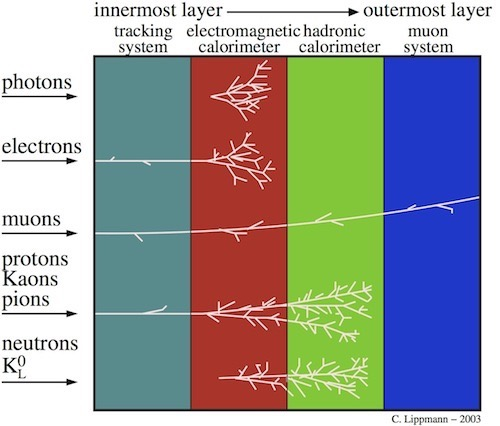

##Import libraries

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# magic command, indicates that graphs should be built directly in the notebook:
%matplotlib inline

##Load and read data

In [1]:
!wget https://github.com/yandexdataschool/mlhep2020-assignments/raw/master/data/1.3.1-logistic-regression/PID-dataset-subsample.csv.gz

--2023-07-26 15:20:08--  https://github.com/yandexdataschool/mlhep2020-assignments/raw/master/data/1.3.1-logistic-regression/PID-dataset-subsample.csv.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/mlhep2020-assignments/master/data/1.3.1-logistic-regression/PID-dataset-subsample.csv.gz [following]
--2023-07-26 15:20:08--  https://raw.githubusercontent.com/yandexdataschool/mlhep2020-assignments/master/data/1.3.1-logistic-regression/PID-dataset-subsample.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13048336 (12M) [application/octet-stream]
Saving to: ‘PID-dataset

In [4]:
df = pd.read_csv('/content/PID-dataset-subsample.csv.gz')
df.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,4783.899908,15.0,0.992629,1.0,1.0,3.2,-0.753252,5.095674,1.0,-0.744993,...,25.0,1.0,-0.272898,-9.828998,23413.300773,1.0,1.0,0.000011,12.092303,-2.605698
1,21113.160174,16.0,-0.454772,1.0,1.0,3.2,-3.027843,14.091743,1.0,1.282079,...,28.0,1.0,-78.682187,8.813811,1612.774429,1.0,1.0,2.742716,4.840911,-53.067288
2,2004.359973,14.0,-0.060743,0.0,1.0,0.0,-2.723425,-0.000016,1.0,0.107044,...,27.0,0.0,-0.017021,-33.895621,-999.000000,0.0,0.0,0.000019,-0.000021,-0.000021
3,12877.429683,14.0,-0.638981,0.0,1.0,3.2,-3.283638,4.084645,1.0,0.079914,...,29.0,1.0,13.235793,9.094493,3562.783455,0.0,1.0,1.645638,1.392493,26.947293
4,73979.062493,18.0,0.484596,1.0,1.0,3.2,-2.441371,8.700628,1.0,0.936483,...,36.0,1.0,-2.929998,0.781402,2286.271726,1.0,1.0,2.742734,0.433102,0.430202


### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

- `Label` - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost".
- `FlagSpd` - flag (0 or 1), if reconstructed track passes through Spd
- `FlagPrs` - flag (0 or 1), if reconstructed track passes through Prs
- `FlagBrem` - flag (0 or 1), if reconstructed track passes through Brem
- `FlagEcal` - flag (0 or 1), if reconstructed track passes through Ecal
- `FlagHcal` - flag (0 or 1), if reconstructed track passes through Hcal
- `FlagRICH1` - flag (0 or 1), if reconstructed track passes through the first RICH detector
- `FlagRICH2` - flag (0 or 1), if reconstructed track passes through the second RICH detector
- `FlagMuon` - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- `SpdE` - energy deposit associated to the track in the Spd
- `PrsE` - energy deposit associated to the track in the Prs
- `EcalE` - energy deposit associated to the track in the Hcal
- `HcalE` - energy deposit associated to the track in the Hcal
- `PrsDLLbeElectron` - delta log-likelihood for a particle candidate to be electron using information from Prs
- `BremDLLbeElectron` - delta log-likelihood for a particle candidate to be electron using information from Brem
- `TrackP` - particle momentum
- `TrackPt` - particle transverse momentum
- `TrackNDoFSubdetector1`  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- `TrackQualitySubdetector1` - chi2 quality of the track fit using hits in the tracking sub-detector1
- `TrackNDoFSubdetector2` - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- `TrackQualitySubdetector2` - chi2 quality of the track fit using hits in the  tracking sub-detector2
- `TrackNDoF` - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- `TrackQualityPerNDoF` - chi2 quality of the track fit per degree of freedom
- `TrackDistanceToZ` - distance between track and z-axis (beam axis)
- `Calo2dFitQuality` - quality of the 2d fit of the clusters in the calorimeter
- `Calo3dFitQuality` - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- `EcalShowerLongitudinalParameter` - longitudinal parameter of Ecal shower
- `HcalDLLbeElectron` - delta log-likelihood for a particle candidate to be electron using information from Hcal
- `HcalDLLbeMuon` - delta log-likelihood for a particle candidate to be using information from Hcal
- `RICHpFlagElectron` - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- `RICHpFlagProton` - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- `RICHpFlagPion` - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- `RICHpFlagKaon` - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- `RICHpFlagMuon` - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- `RICH_DLLbeBCK`  - delta log-likelihood for a particle candidate to be background using information from RICH
- `RICH_DLLbeKaon` - delta log-likelihood for a particle candidate to be kaon using information from RICH
- `RICH_DLLbeElectron` - delta log-likelihood for a particle candidate to be electron using information from RICH
- `RICH_DLLbeMuon` - delta log-likelihood for a particle candidate to be muon using information from RICH
- `RICH_DLLbeProton` - delta log-likelihood for a particle candidate to be proton using information from RICH
- `MuonFlag` - muon flag (is this track muon) which is determined from muon stations
- `MuonLooseFlag` - muon flag (is this track muon) which is determined from muon stations using looser criteria
- `MuonLLbeBCK` - log-likelihood for a particle candidate to be not muon using information from muon stations
- `MuonLLbeMuon` - log-likelihood for a particle candidate to be muon using information from muon stations
- `DLLelectron` - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- `DLLmuon` - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- `DLLkaon` - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- `DLLproton` - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- `GhostProbability` - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

Let's check the data types and the number of missed values in the dataset:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   TrackP                           60000 non-null  float64
 1   TrackNDoFSubdetector2            60000 non-null  float64
 2   BremDLLbeElectron                60000 non-null  float64
 3   MuonLooseFlag                    60000 non-null  float64
 4   FlagSpd                          60000 non-null  float64
 5   SpdE                             60000 non-null  float64
 6   EcalDLLbeElectron                60000 non-null  float64
 7   DLLmuon                          60000 non-null  float64
 8   RICHpFlagElectron                60000 non-null  float64
 9   EcalDLLbeMuon                    60000 non-null  float64
 10  TrackQualitySubdetector2         60000 non-null  float64
 11  FlagPrs                          60000 non-null  float64
 12  DLLelectron       

*There are 60,000 rows in the dataset with 48 float features and a target output (Label), and there are no NaN values.*

Let's visualize target variable distribution.

<Axes: xlabel='Label', ylabel='count'>

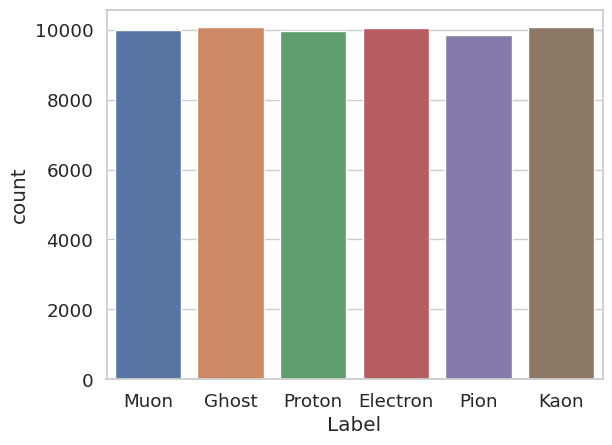

In [12]:
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
sns.countplot(data=df, x="Label")

In [13]:
df.Label.value_counts(True)

Kaon        0.167883
Ghost       0.167817
Electron    0.167567
Muon        0.166467
Proton      0.166317
Pion        0.163950
Name: Label, dtype: float64

💡*There is a union distribution of the Label, the dataset is balanced with five possible outcomes.*

## Data Preparation

 Let's separate target variable

In [14]:
X = df.drop('Label', axis=1)
y = df['Label']

### Correlation heatmap

We can use seaborn's `heatmap` function to determine which pairs of variables are most closely related.

Correlation is a statistical measure that expresses the strength of the relationship between two variables. The two main types of correlation are positive and negative.

$r = \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{%
 \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}$

Positive correlation occurs when two variables move in the same direction; as one increases, so do the other. A negative correlation occurs when two variables move in opposite directions; as one increases, the other decreases.

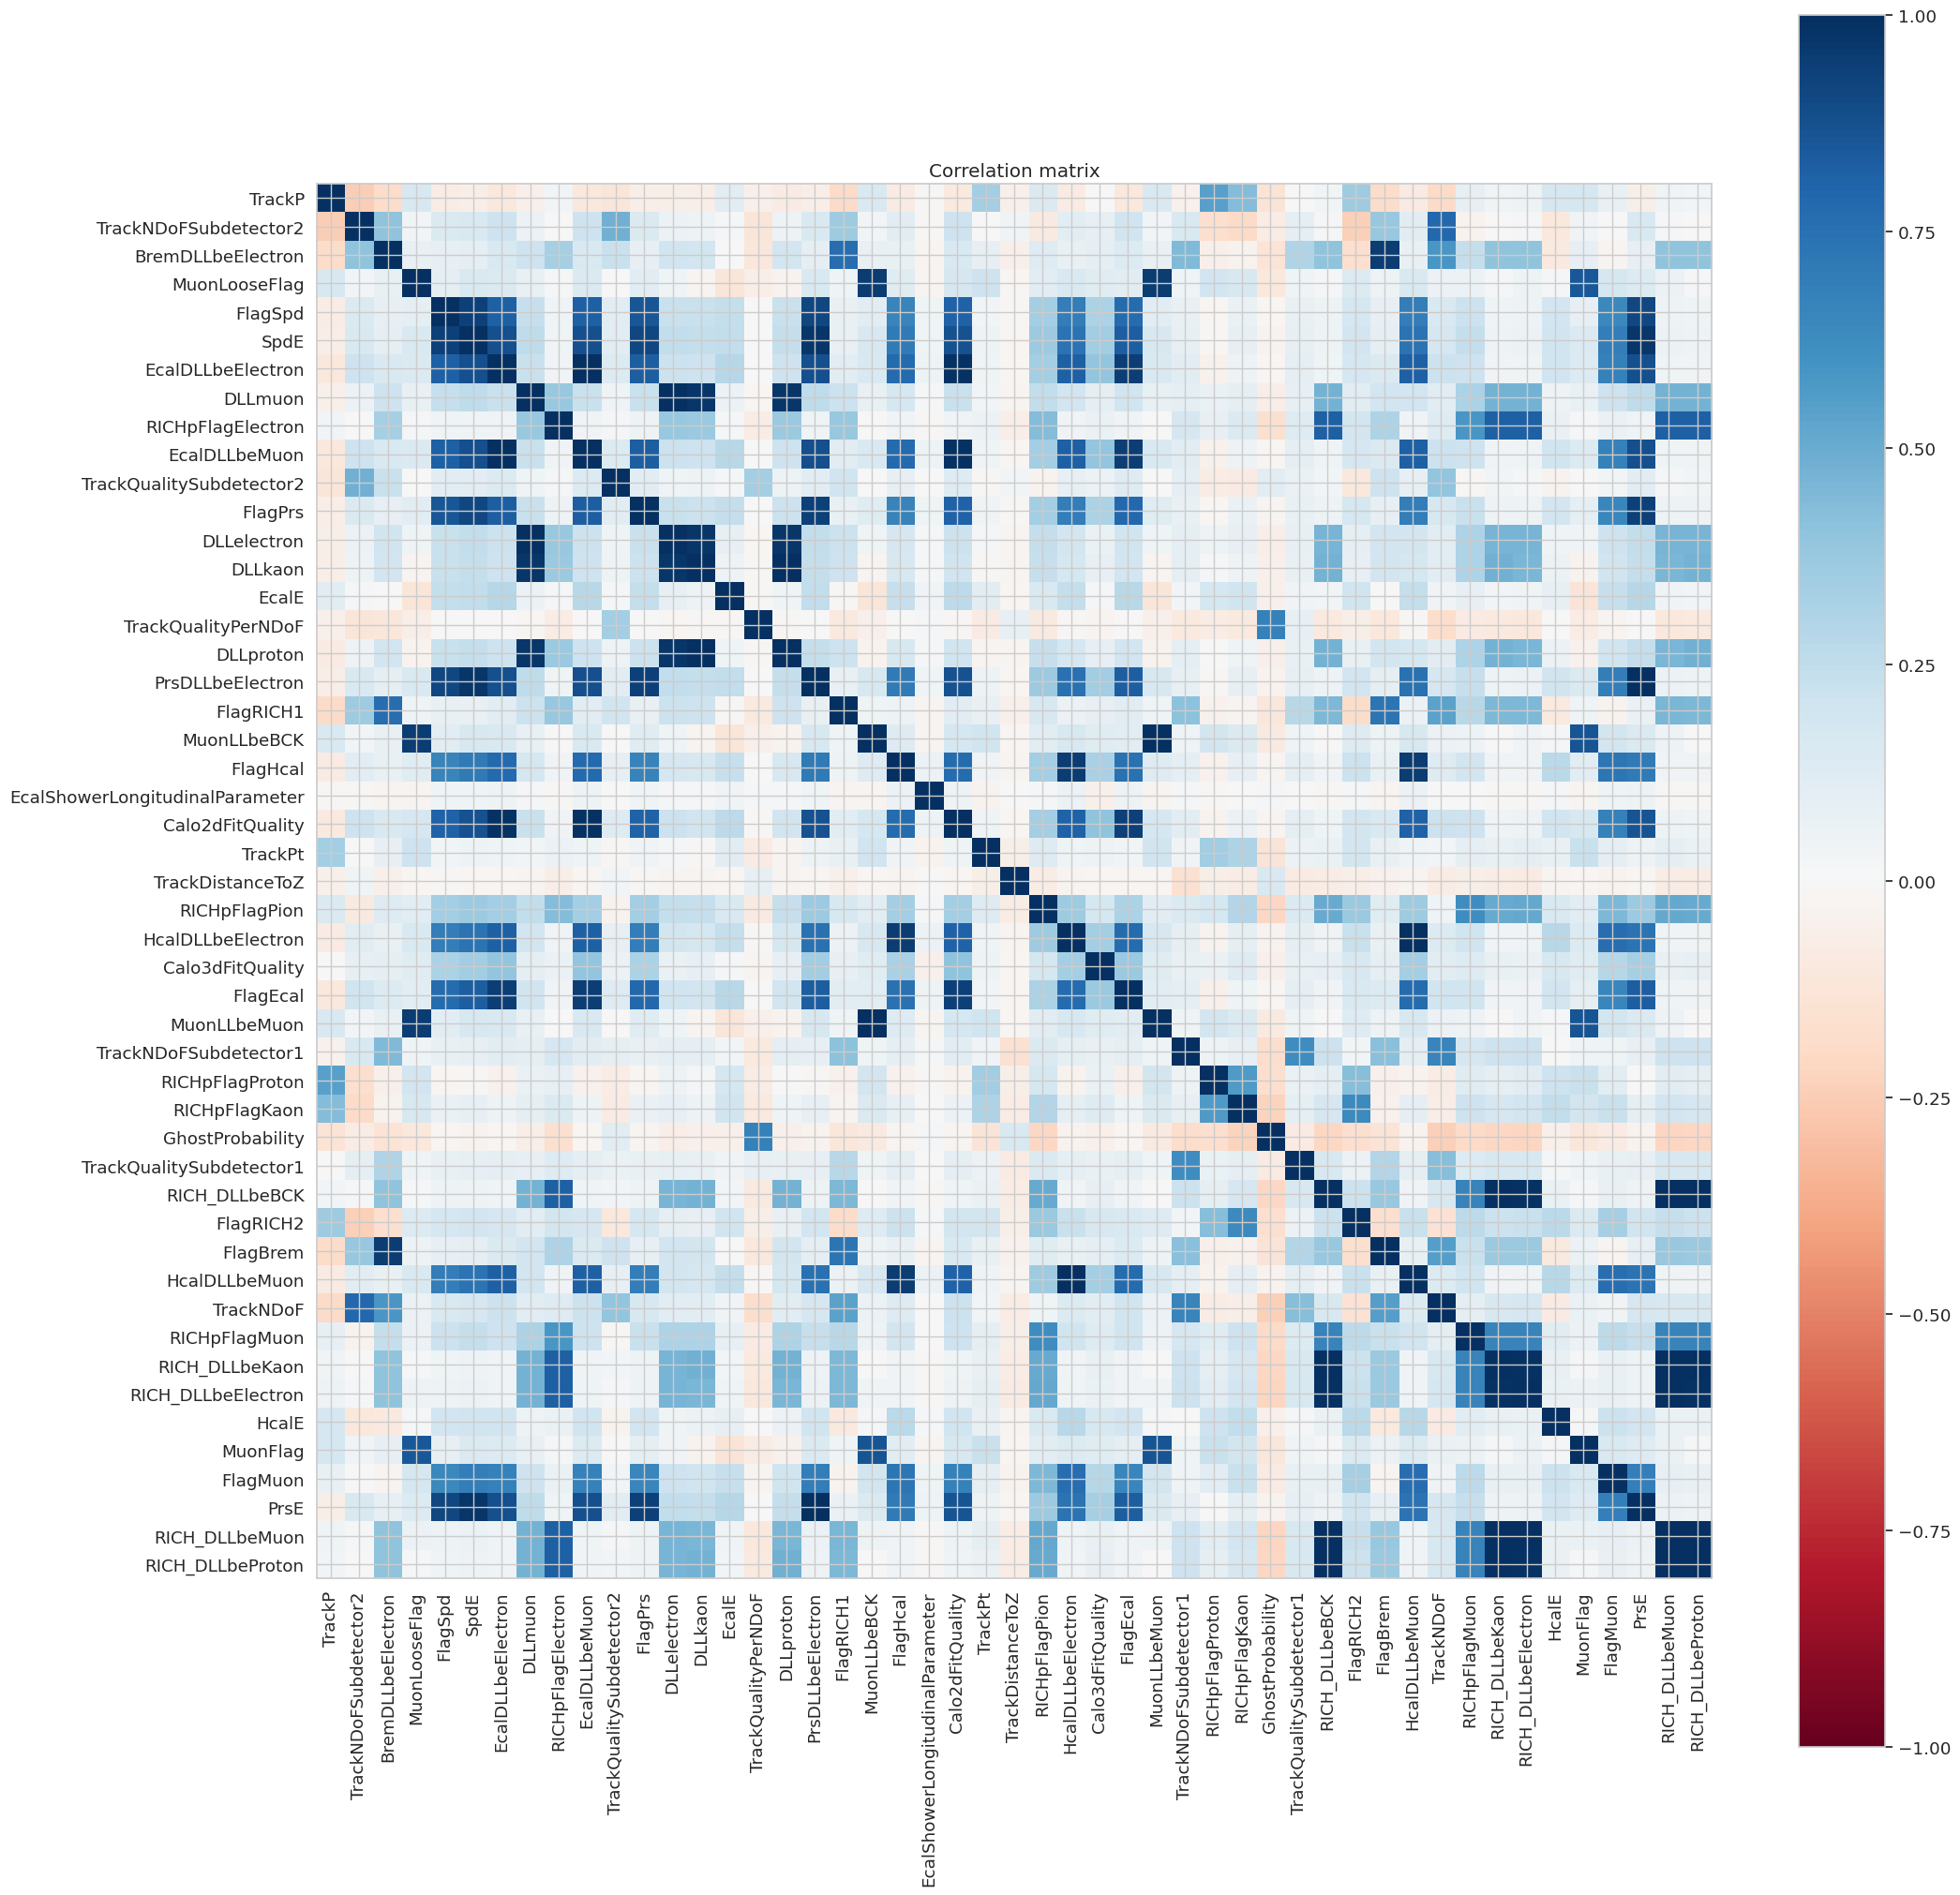

In [15]:
x = np.asarray(X)
features = X.columns
x_cov = np.cov(x.T)
sigma = np.sqrt(np.diag(x_cov))
x_cor = x_cov / np.outer(sigma, sigma)

# plt.figure(figsize=(12, 12))
plt.figure(figsize=(24, 24))
vmax = 1.0
plt.imshow(x_cor, interpolation='nearest', vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu)
plt.title("Correlation matrix", )
plt.colorbar()
plt.yticks(np.arange(len(features)), features)
plt.xticks(rotation=90)
_ = plt.xticks(np.arange(len(features)), features)

💡*One can notice strong positive correlation between the following features:*

`BremDLLbeElectron` and `FlagBrem`,

`MuonLoosFlag` and `MuonLLLbeBCK`,

`MuonLoosFlag` and `MuonLLLbeMuon`...



Let's remove Flags form the data.

In [16]:
not_Flag_cols = [col for col in X.columns if 'Flag' not in col]

In [17]:
not_Flag_cols

['TrackP',
 'TrackNDoFSubdetector2',
 'BremDLLbeElectron',
 'SpdE',
 'EcalDLLbeElectron',
 'DLLmuon',
 'EcalDLLbeMuon',
 'TrackQualitySubdetector2',
 'DLLelectron',
 'DLLkaon',
 'EcalE',
 'TrackQualityPerNDoF',
 'DLLproton',
 'PrsDLLbeElectron',
 'MuonLLbeBCK',
 'EcalShowerLongitudinalParameter',
 'Calo2dFitQuality',
 'TrackPt',
 'TrackDistanceToZ',
 'HcalDLLbeElectron',
 'Calo3dFitQuality',
 'MuonLLbeMuon',
 'TrackNDoFSubdetector1',
 'GhostProbability',
 'TrackQualitySubdetector1',
 'RICH_DLLbeBCK',
 'HcalDLLbeMuon',
 'TrackNDoF',
 'RICH_DLLbeKaon',
 'RICH_DLLbeElectron',
 'HcalE',
 'PrsE',
 'RICH_DLLbeMuon',
 'RICH_DLLbeProton']

In [18]:
X = X[not_Flag_cols]

In [19]:
X.shape

(60000, 34)

### Spliting data

We'll use skleran train-test split helper function to split X and Y into train and test data.

- Train Dataset: Used to fit model.
- Test Dataset: Used to evaluate the fit model.

In [5]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Let`s check whether the train data has outliers.

An outlier is a data point that is noticeably different from the rest. Many machine learning models are easily impacted by the outliers in the training data.

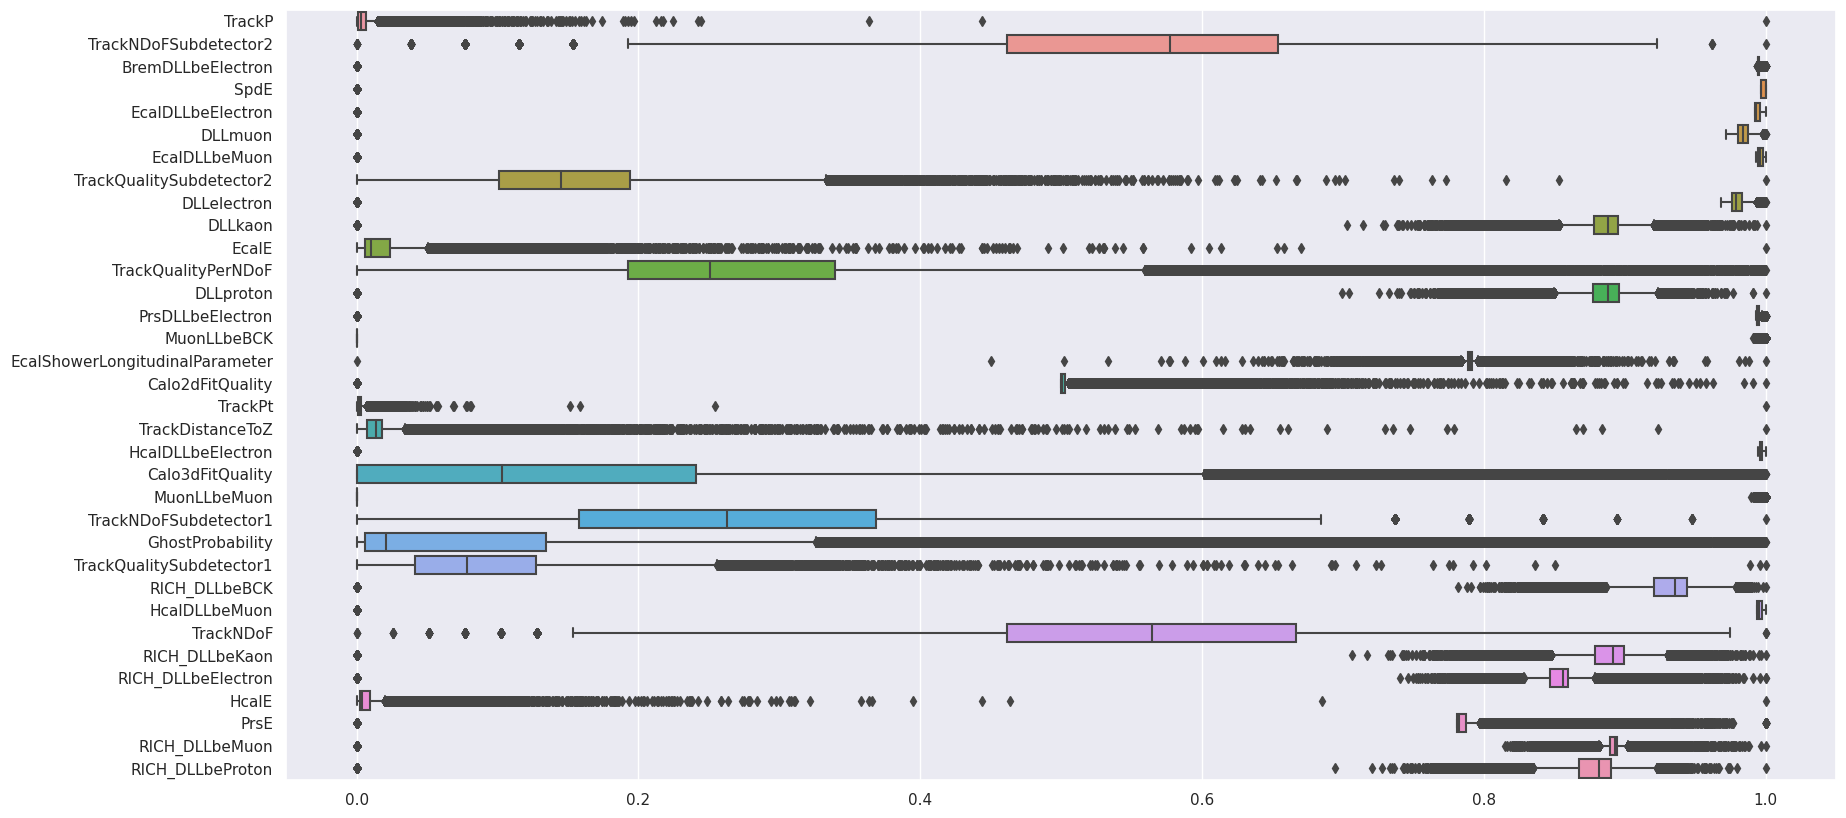

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X_train) # normalization
df_array_to_df = pd.DataFrame(df_scaled, columns = X_train.columns) # convert array into dataframe
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.0)
sns.boxplot(data=df_array_to_df, orient="h");

###Standartization

Linear models like the features to be of roughly the same scale. Let's use sklearn's `StandardScaler` for it. This transformation brings the values of each feature to zero mean and unit variance:

$$
X_{new} = \frac{X - \mu}{\sigma},
$$

where $\mu$ is the mean value of the feature,

$\sigma$ - standard deviation of feature values.

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

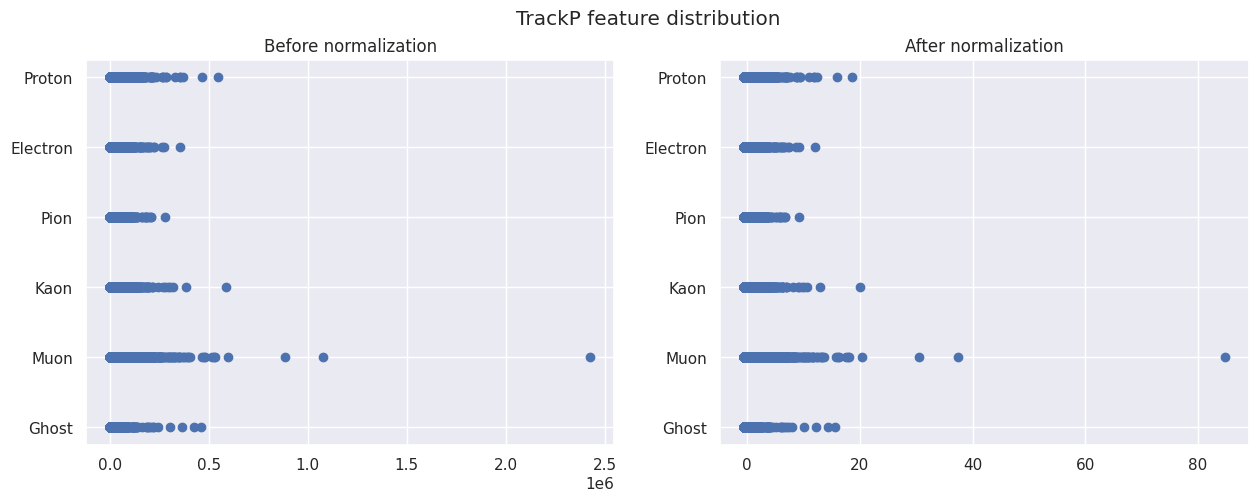

In [24]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(X_train['TrackP'], y = y_train)
ax2.scatter(X_train_scaled[:,0], y = y_train)

fig.suptitle('TrackP feature distribution')
ax1.set_title('Before normalization')
ax2.set_title('After normalization');

In [27]:
features = list(X_train.columns)

In [28]:
labels = y_train.unique()

In [29]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = features)

In [30]:
X_train_scaled_df['Label']= y_train

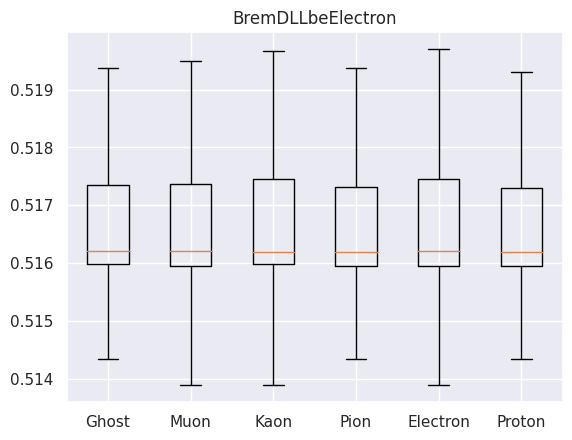

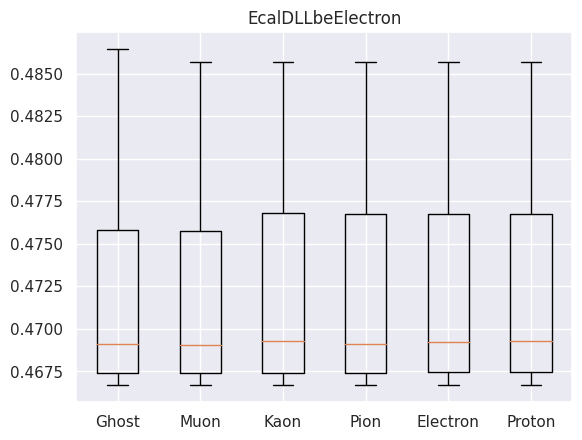

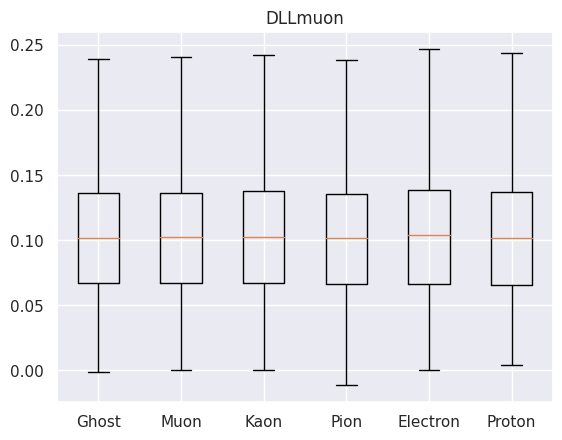

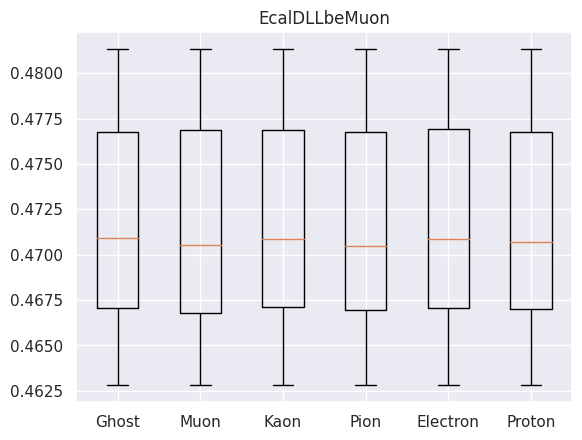

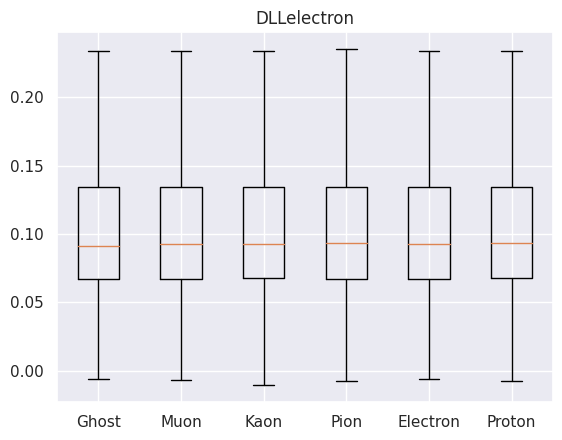

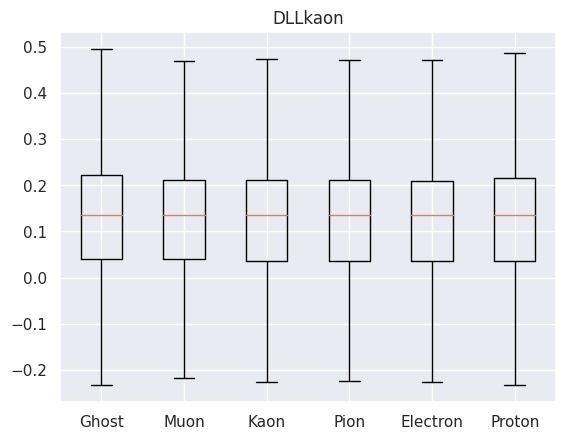

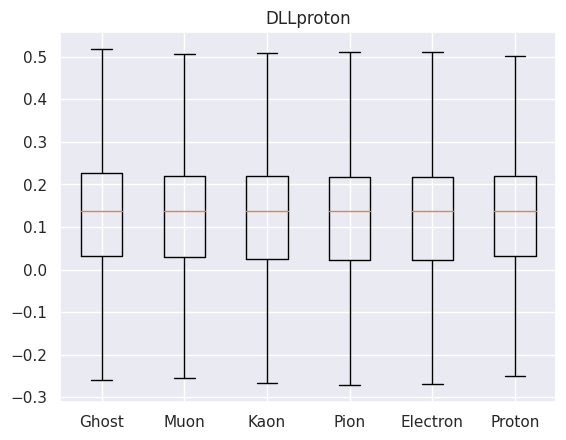

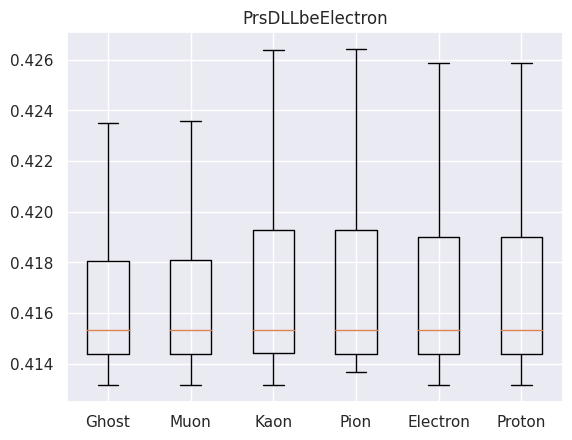

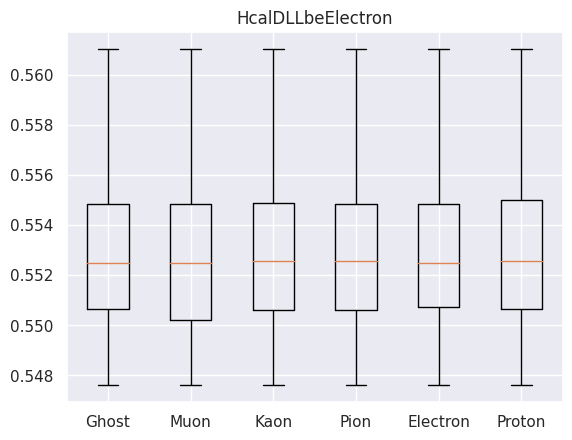

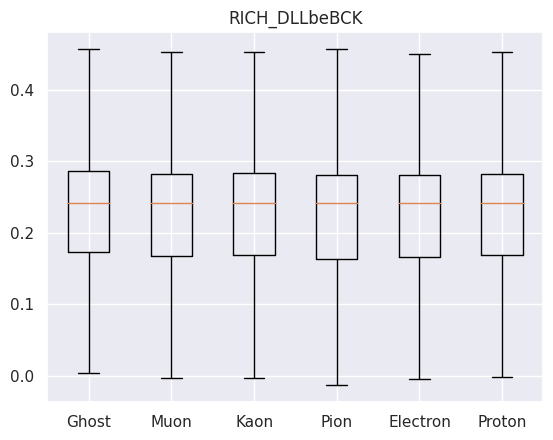

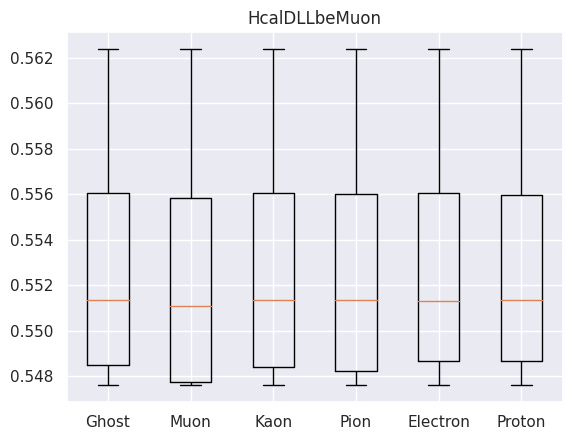

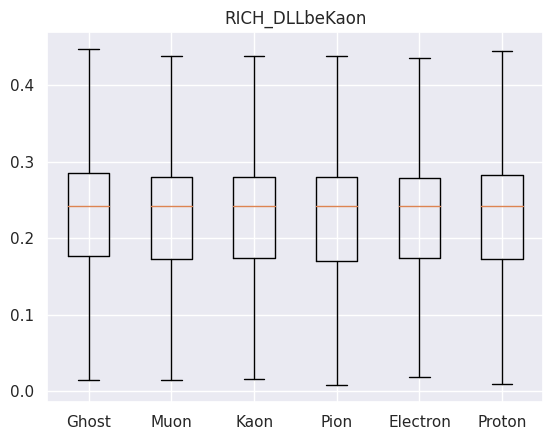

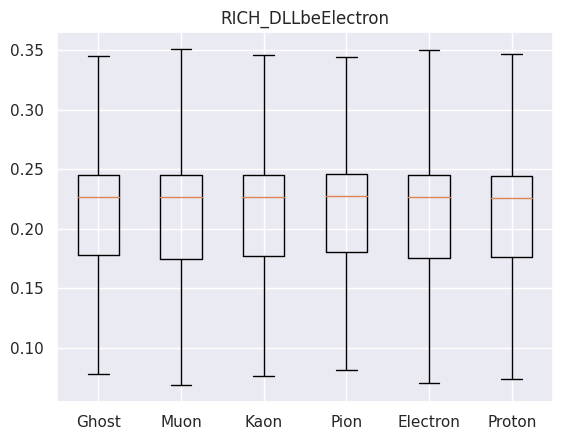

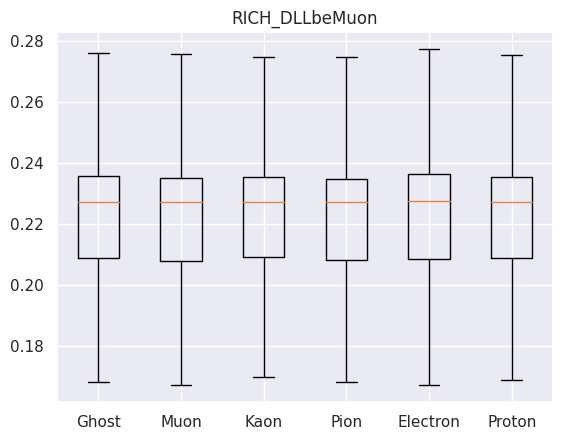

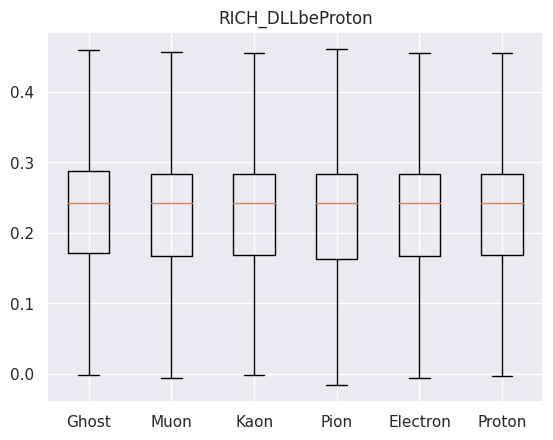

In [31]:
for s in features:
    if s.find("DLL") < 0:
        continue
    plt.figure()
    dll = list([X_train_scaled_df[X_train_scaled_df.Label == l][s] for l in labels])
    plt.title(s)
    plt.boxplot(dll, showfliers=False)
    plt.xticks(np.arange(len(labels))+1, labels)
    plt.show()

## Model Training

<a target="_blank"><img src="https://1.bp.blogspot.com/-Sk5yumiKjAQ/XO4S7ocnHXI/AAAAAAAADCA/mw_XfK7ICdgr_NjzR1h8e8PJ1k7Gg3mGwCLcBGAs/s1600/programing-ml.png"
alt="IMAGE ALT TEXT HERE" width="620" border="0" /></a>

The choice of a method for building a model is influenced by a set of features, sample size, intuition about what is the relationship between the input variables and the target one. But often the decision is made on the basis of which model worked best.


We will compare basic algorithms for solving classification problem:

* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)


All of these methods are already realized in **scikit-learn** library modules.

<a target="_blank"><img src="https://neurohive.io/wp-content/uploads/2019/06/1200px-Scikit_learn_logo_small.svg.png"
alt="IMAGE ALT TEXT HERE" width="360" border="0" /></a>

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

**sklearn** library has a universal set of steps for making predictions with model:

1. *Model initialization*


```python
my_model = choosen_model()
```

2. *Model training*

```python
my_model.fit(X_train, y_train)
```

3. *Prediction on test data*

```python
my_model.predict(X_test)
```

### Logistic Regression

#### Binary classification: Muon vs all

Before diving into multi-class classification, let`s start with binary classification!

In [33]:
labels

array(['Ghost', 'Muon', 'Kaon', 'Pion', 'Electron', 'Proton'],
      dtype=object)

In [34]:
y_train_binary = y_train.replace(['Ghost', 'Kaon', 'Pion', 'Electron', 'Proton'], 'Non-Muon')
y_test_binary = y_test.replace(['Ghost', 'Kaon', 'Pion', 'Electron', 'Proton'], 'Non-Muon')

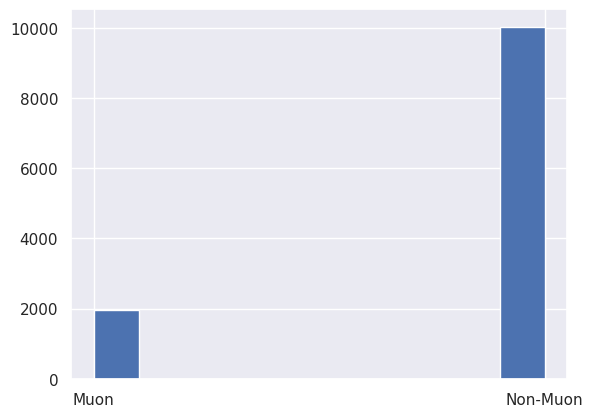

In [35]:
y_test_binary.hist();

Train binary classification model

In [36]:
logreg_model_binary = LogisticRegression()
logreg_model_binary

LogisticRegression()

Let's train the model on raw data.

In [37]:
logreg_model_binary.fit(X_train, y_train_binary)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Predict on test data

In [38]:
y_pred_logreg_binary = logreg_model_binary.predict(X_test)

In [39]:
y_pred_logreg_binary

array(['Muon', 'Muon', 'Non-Muon', ..., 'Muon', 'Non-Muon', 'Non-Muon'],
      dtype=object)

Let`s find the share of accuarte predictions.

In [40]:
sum(y_pred_logreg_binary == y_test_binary)/len(y_test_binary)

0.9363333333333334

Is it good enough?

In [41]:
y_pred_dummy = ['Non-Muon']*len(y_test_binary)

In [42]:
sum(y_pred_dummy == y_test_binary)/len(y_test_binary)

0.83575

In [ ]:
R0Cauc?

We will look at another metrics a little bit later.

#### Multi-class classification

SKlearn's LogisticRegression class takes a parameter called multiclass to tune the algorithm for multiclass scenario. LogisticRegression uses two approaches for multiclass problem.

**1. One-Vs-Rest (OVR)**

One-vs.-rest (or one-vs-all, OvA) classifier involves training a single classifier per class, with the samples of that class as positive sample and all other samples as negatives.

For OVA, the assumption is that there are  𝑁  independent classification problems, meaning  𝑁  classes, and for each class we learn a logistic (probability) model. The key assumption is that each of these problems is independent of the other  𝑁−1  logistic regression problems. Hence for each sample we either classify this as class  𝑌𝑖  or not. This is repeated for all classes.

**2. Multinomial**

The alternative to One vs Rest classifier is the multinomial logistic regression classifier. The multinomial classifier does not classifier each class seperately, instead it uses the softmax function to predict if a single data point falls in one of the  𝑁  classes.

Most of the times you may not see a significant difference in the results but one benifit is that you model the entire distribution  𝑃(𝑌𝑖=𝑐)=SoftMax(𝛽1,𝑥1,𝛽2,𝑥2....𝛽𝑛,𝑥𝑛,)  rather than the individual distributions  𝑃(𝑌𝑖=𝑐).

❔*What method should you use*

💡It typically pays to try both and see how well it works on your validation/test set.

Let's train the OVR model on raw data.

In [43]:
logreg_model = LogisticRegression(multi_class='ovr')

In [46]:
logreg_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='ovr')

In [47]:
y_pred_logreg = logreg_model.predict(X_test)

In [48]:
sum(y_pred_logreg == y_test)/len(y_test)

0.5244166666666666

#### Practice 1.

Set the multiclass to 'multinomial' and make predictions with new model.

In [49]:
logreg_model_multi = LogisticRegression(multi_class='Multinomial')

#### Model assessment

In [50]:
y_test = y_test.reset_index(drop=True)

In [51]:
y_test.nunique()

6

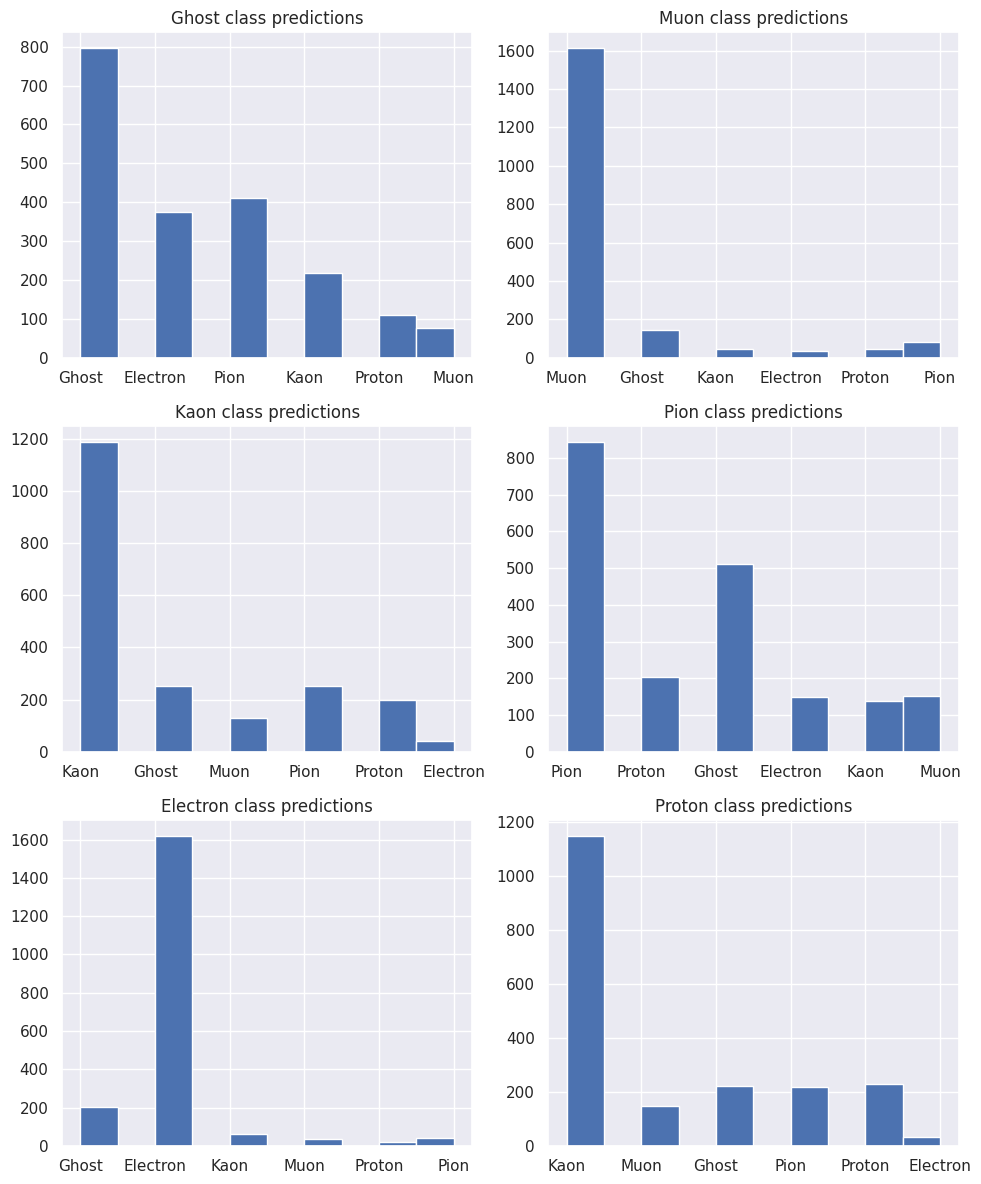

In [52]:
def preds_hists(labels):
    fig = plt.figure(figsize=(10, 12)) # set a size for the surrounding plot
    n = len(labels)
    ncols = 2
    nrows = 3
    k = 1
    for i in range(n):
        col_i = labels[i]
        ax = plt.subplot(nrows, ncols, k)
        plt.hist(y_pred_logreg[y_test[y_test == col_i].index])
        plt.title(f'{col_i} class predictions')
        k += 1
    plt.tight_layout() # fit labels and ticks nicely together
    plt.show() # only called once, at the end of the function

preds_hists(labels)

The function for calculating accuracy is implemented in the **sklearn** library and is called **`accuracy_score`**.

❓Can we use *other metrics* for *multiclass classification* but *accuarcy*

<a target="_blank"><img src="https://onlinehelp.explorance.com/blueml/Content/Resources/Images/ml/truefalsepositives.png"
alt="IMAGE ALT TEXT HERE" width="600" border="0" /></a>

The majority of classification metrics are defined for *binary cases* by default. In extending these binary metrics to multiclass, several averaging techniques are used.

✅ We can apply **One-vs-Rest strategy** that converts a multiclass problem into a series of binary tasks for each class in the target.


Here are averaging techniques applicable to multiclass classification:

- *macro*: an arithmetic mean of all metrics across classes. This technique gives equal weights to all classes making it a good option for balanced classification tasks.
-  *weighted*: accounts for class imbalance by computing the average of binary metrics weighted by the number of samples of each class in the target.

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [54]:
print('Logistic regression accuracy: {:.2f}' .format(accuracy_score(y_test, y_pred_logreg)))

Logistic regression accuracy: 0.52


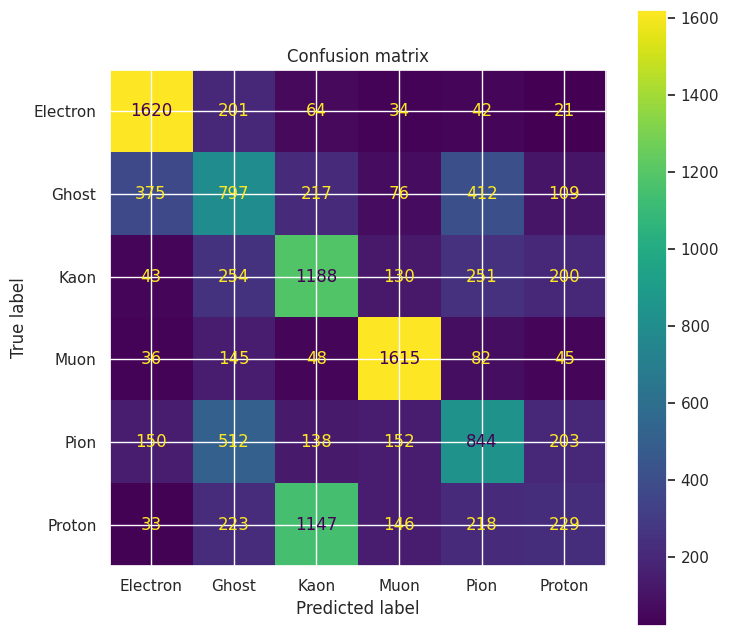

In [55]:
cm = confusion_matrix(y_test, y_pred_logreg)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Electron','Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'])
fig, ax = plt.subplots(figsize=(8,8))
plt.title("Confusion matrix")
cmd.plot(ax=ax);

💡Let`s calculate the Precision of the Electron

*True positives for the Electron is the top-left cell (1363). False positives are all the cells where other types of particles are predicted as Electron.*

*These are the cells below the top-left cell (436 + 345 + 66 + 381 + 305 = 1533). So, precision will be:*

**Precision (Electron)**: *1363 / (1363 + 1533) = 0.47 — a terrible score.*


💡Let`s now calculate the Recall of the Kaon

*There are 292 true positives (3nd row, 3nd column). False negatives would be any occurrences where Kaon partticles were classified as others. These would be the cells to the left and right of the true positives cell (345 + 278 + 161 + 371 + 619 = 1774). So, the recall will be:*

**Recall (Kaon)**: *292 / (292 + 1774) = 0.14 — not a good score either.*




In [ ]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

    Electron       0.47      0.69      0.56      1982
       Ghost       0.36      0.46      0.41      1986
        Kaon       0.35      0.14      0.20      2066
        Muon       0.74      0.81      0.78      1971
        Pion       0.32      0.26      0.28      1999
      Proton       0.35      0.35      0.35      1996

    accuracy                           0.45     12000
   macro avg       0.43      0.45      0.43     12000
weighted avg       0.43      0.45      0.43     12000



Now, let`s use standartized data.

In [ ]:
logreg_model_new = LogisticRegression()
logreg_model_new.fit(X_train_scaled, y_train)
print(classification_report(y_test, logreg_model_new.predict(X_test_scaled)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    Electron       0.81      0.87      0.84      1982
       Ghost       0.72      0.70      0.71      1986
        Kaon       0.60      0.57      0.58      2066
        Muon       0.86      0.86      0.86      1971
        Pion       0.64      0.72      0.68      1999
      Proton       0.62      0.55      0.58      1996

    accuracy                           0.71     12000
   macro avg       0.71      0.71      0.71     12000
weighted avg       0.71      0.71      0.71     12000



💡*As we see, standartization influence deeply linear model.*

### KNN

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
y_preds_knn = knn_model.predict(X_test_scaled)
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

    Electron       0.54      0.74      0.62      1982
       Ghost       0.67      0.67      0.67      1986
        Kaon       0.37      0.42      0.39      2066
        Muon       0.84      0.83      0.83      1971
        Pion       0.49      0.39      0.43      1999
      Proton       0.38      0.28      0.32      1996

    accuracy                           0.55     12000
   macro avg       0.55      0.55      0.54     12000
weighted avg       0.55      0.55      0.54     12000



💡*K-NN has difficulty with observations spread out in the feature space. K-NN is sensitive to outliers.*

In [ ]:
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
INPUT_DIM  = X_train_scaled.shape[1]
initial_type = [('float_input', FloatTensorType([None, INPUT_DIM]))]
onx = convert_sklearn(knn_model, initial_types=initial_type)
with open("models/test.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [ ]:
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("models/test.onnx")

input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

print("Inputs: {}".format([x.name for x in sess.get_inputs()]))
print("Outputs: {}".format([x.name for x in sess.get_outputs()]))

pred = sess.run([label_name], {input_name: X_test_scaled.astype(numpy.float32)})

In [ ]:
print(classification_report(y_test, pred[0]))

### Decision tree

#### Practice 2.

Train DecisionTreeClassifier and print out the classifiction report. Does the model outperform logistic regression?

In [ ]:
dt_model = #YOUR CODE HERE#

              precision    recall  f1-score   support

    Electron       0.79      0.81      0.80      1982
       Ghost       0.63      0.62      0.63      1986
        Kaon       0.52      0.51      0.52      2066
        Muon       0.85      0.83      0.84      1971
        Pion       0.60      0.61      0.61      1999
      Proton       0.51      0.50      0.50      1996

    accuracy                           0.65     12000
   macro avg       0.65      0.65      0.65     12000
weighted avg       0.65      0.65      0.65     12000



💡Decision trees are more likely to overfit the data since they can split on many different combination of features whereas in logistic regression we associate only one parameter with each feature.

### Gradient Boosting

We will use [Histogram-based version of Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) method as it is faster.

In [ ]:
gb_model = HistGradientBoostingClassifier()
gb_model.fit(X_train_scaled, y_train)
y_preds_gb = gb_model.predict(X_test_scaled)
print(classification_report(y_test, y_preds_gb))

              precision    recall  f1-score   support

    Electron       0.86      0.90      0.88      1982
       Ghost       0.73      0.79      0.76      1986
        Kaon       0.63      0.58      0.60      2066
        Muon       0.91      0.90      0.90      1971
        Pion       0.72      0.75      0.73      1999
      Proton       0.61      0.56      0.59      1996

    accuracy                           0.75     12000
   macro avg       0.74      0.75      0.74     12000
weighted avg       0.74      0.75      0.74     12000



In [ ]:
gb_model = HistGradientBoostingClassifier(max_iter = 200)
gb_model.fit(X_train_scaled, y_train)
y_preds_gb = gb_model.predict(X_test_scaled)
print(classification_report(y_test, y_preds_gb))

              precision    recall  f1-score   support

    Electron       0.87      0.89      0.88      1982
       Ghost       0.72      0.79      0.75      1986
        Kaon       0.62      0.58      0.60      2066
        Muon       0.90      0.90      0.90      1971
        Pion       0.72      0.75      0.73      1999
      Proton       0.62      0.56      0.59      1996

    accuracy                           0.74     12000
   macro avg       0.74      0.74      0.74     12000
weighted avg       0.74      0.74      0.74     12000



# Electron particle momentum (TrackP) prediction

Let`s solve a regression task where we need to predict the momentum of electron.

In [ ]:
data = df[df.Label == 'Electron']

In [ ]:
X = data.drop(['Label', 'TrackP'], axis=1)
y = data['TrackP']

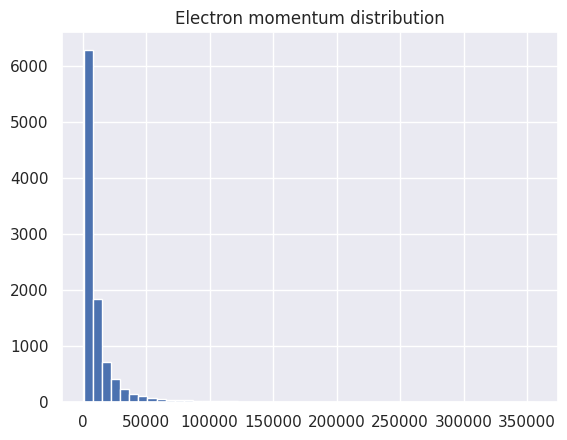

In [ ]:
fig= plt.hist(y, bins = 50)
plt.title("Electron momentum distribution");

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Practice 3.

Standartize the data.

In [ ]:
#YOUR CODE HERE#
X_train_scaled, X_test_scaled = #YOUR CODE HERE#

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
models = {
    'linear_regression': LinearRegression().fit(X_train_scaled, y_train),
    'knn': KNeighborsRegressor().fit(X_train_scaled, y_train),
    'decision_tree': DecisionTreeRegressor().fit(X_train_scaled, y_train),
    'gradient_boost': GradientBoostingRegressor().fit(X_train_scaled, y_train)
}

We will assess the quality of the regression with these metrics:

* **MAE** (**mean_absolute_error**) - mean absolute error $|y_i - \hat{y}_i|$
* **RMSE** is the square root of **mean_squared_error** where **mean_squared_error** is the root mean square error $(y_i - \hat{y}_i)^2$
* **r2_score** - regression model determination coefficient. Models with a coefficient of determination above 0.8 can be considered quite good. The equality of the coefficient of determination 1 means that the variable being explained is exactly described by the considered model.

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
out = {'model': [], 'mae': [], 'rmse': [], 'r2_score': []}

for name, model in models.items():
    predictions = model.predict(X_test_scaled)

    mae  = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions)**0.5
    r2  = r2_score(y_test, predictions)

    out['model'].append(name)
    out['mae'].append(mae)
    out['rmse'].append(rmse)
    out['r2_score'].append(r2)


In [ ]:
summary = pd.DataFrame(out).set_index('model')
summary

,mae,rmse,r2_score
model,,,
linear_regression,4598.886065,11069.661297,0.614320
knn,3478.362345,10322.380310,0.664634
decision_tree,3007.712308,11239.012512,0.602429
gradient_boost,2565.441114,8812.555278,0.755565


### Bonus: Cross-validation

By default, delayed sampling is used to properly validate models. That is, we split our data into a training sample, a test sample, and a deferred sample. Accordingly, we train the model on the training one, during training we check the result on the test set, and at the end of training, in order to assess the quality of the model, we calculate the error on the deferred set.


However, with this approach, only the training set is involved in the training of the model. We use test and deferred only for testing. If we have little data - this is an unaffordable luxury.

Another popular approach is **cross-validation**. The essence of the method is that we do not one partition of the dateset, but several partitions in such a way that all data is used both in training and for verification. Such partitions are called **folds**.


The advantages of this approach:
* use all the data for training;
* we can evaluate the stability of the model. If the errors obtained on different folds are very different, then the model is unstable.

The disadvantage of the method is that we need to train not one model, but several (as many as we have chosen folds).

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
kfold

KFold(n_splits=5, random_state=123, shuffle=True)

In [ ]:
gbr = GradientBoostingRegressor()

In [ ]:
r2_scores = cross_val_score(gbr, X_train_scaled, y_train, cv=kfold, scoring='r2')
r2_scores

array([0.7042313 , 0.7786889 , 0.74360565, 0.76760844, 0.84001694])

In [ ]:
print(np.round(r2_scores.mean(), 2), '+-', np.round(r2_scores.std(),2))

0.77 +- 0.04


💡*As one can see, **`sklearn`** has the same procedures for training different models. *italicised text*


*We can use KNN, decision tree and gradient boosting algorithms for both classification and regression tasks.*

*Cross-validation allows to use the whole dataset for a model training.*